# Histopathologic Cancer Detection

#### Charlie Bailey (peba2926)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall, F1Score, AUC
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

## Environment Setup

This project utilizes TensorFlow with GPU acceleration on Apple Silicon (M-series) hardware. Due to specific version requirements and GPU compatibility, the following setup is recommended:

#### Requirements
- Python 3.10.x (TensorFlow compatibility requirement)
- tensorflow-macos
- tensorflow-metal (for Apple Silicon GPU support)

In [2]:
# Confirm TensorFlow is correctly setup and has access to local GPUs for training
print(tf.__version__)
print("Local GPUs::: ", tf.config.list_physical_devices('GPU'))

# Set a tf random seed
tf.random.set_seed(42)

2.16.2
Local GPUs:::  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Project Introduction
The goal of this project is to identify metastatic cancer in small image patches taken from larger digital pathology scans.

#### Data Source
The dataset for this project comes from the Histopathologic Cancer Detection Competition hosted on [Kaggle](http://kaggle.com/competitions/histopathologic-cancer-detection/overview). This dataset is a slightly modified version of the PatchCamelyon (PCam) [benchmark dataset](https://github.com/basveeling/pcam). This dataset was provided by Bas Veeling, with additional input from Babak Ehteshami Bejnordi, Geert Litjens, and Jeroen van der Laak.

#### Problem Description
The ML problem presented is a binary image classification task, similar to the MNIST dataset. The task is to classify small pathology images. A positive label indicates that the center 32x32 region of a given image contains at least one pixel of tumor tissue. A negative label indicates the opposite.

#### Data Description
The dataset for this project is in two forms. The first is a train_labels `.csv` file with 220,025 instances of classified image ids. The features in this file are:

1. id - a string id of a given image
2. label - an int binary classification label (0 or 1)

`1 = Positive (has cancer)`

`0 = Negative (does not have cancer)`

The second data form for this project are two folders contain `.tif` images—each with a given unique id. The images in the `train` folder have ids that correspond to the ids in the `train_labels.csv` file. The images in the `test` folder do not have a corresponding label.

There are 57,458 instances in the `test` folder.

## EDA

In [3]:
df_train = pd.read_csv('./data/train_labels.csv')
df_train.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


In [4]:
# confirm dataframe contains correct instances, columns and datatypes
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [5]:
# check for missing values
df_train.isnull().sum()

id       0
label    0
dtype: int64

In [6]:
# check for duplicates
df_train.duplicated().sum()

0

In [55]:
# loader for N randomly sampled images
def load_N_images(df, path, N=1000):
    # randomly sample N images from the dataframe
    subset_df = df.sample(n=N)
    images = []
    labels = []
    
    # iterate over subset with added tqdm progress bar
    for _, row in tqdm(subset_df.iterrows(), total=subset_df.shape[0]):
        image_id = row['id']
        label = row['label']

        try:
            # get the path to the current image and load it
            image_path = os.path.join(path, f'{image_id}.tif')
            image = Image.open(image_path)
            # ensure all images are 96x96
            image = image.resize((96,96))
            image = np.array(image)
            images.append(image)
            labels.append(label)

        except Exception as e:
            print(f"Error loading image {image_id}: {e}")
            continue

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [56]:
# check if images are already loaded to avoid memory overload
if 'images' not in locals() or 'images' not in globals():
    path = './data/train'
    # load 1000 images to start
    images, labels = load_N_images(df_train, path, 1000)
else:
    print("Images already loaded")

# Check that the first dimension shape of the images and labels are the same
print(images.shape)
print(labels.shape)

Images already loaded
(1000, 96, 96, 3)
(1000,)


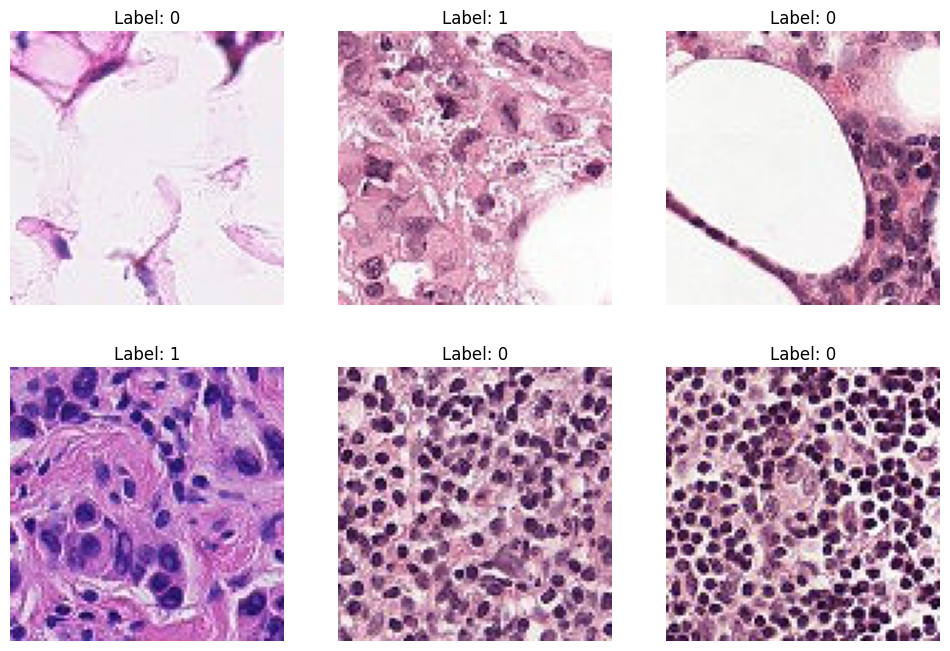

In [57]:
# plot 6 images for visual inspection
def plot_images(images, labels):
    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()
plot_images(images, labels)

Counts of each label:
0    600
1    400
Name: count, dtype: int64

Percentages of each label:
0    60.0
1    40.0
Name: count, dtype: float64



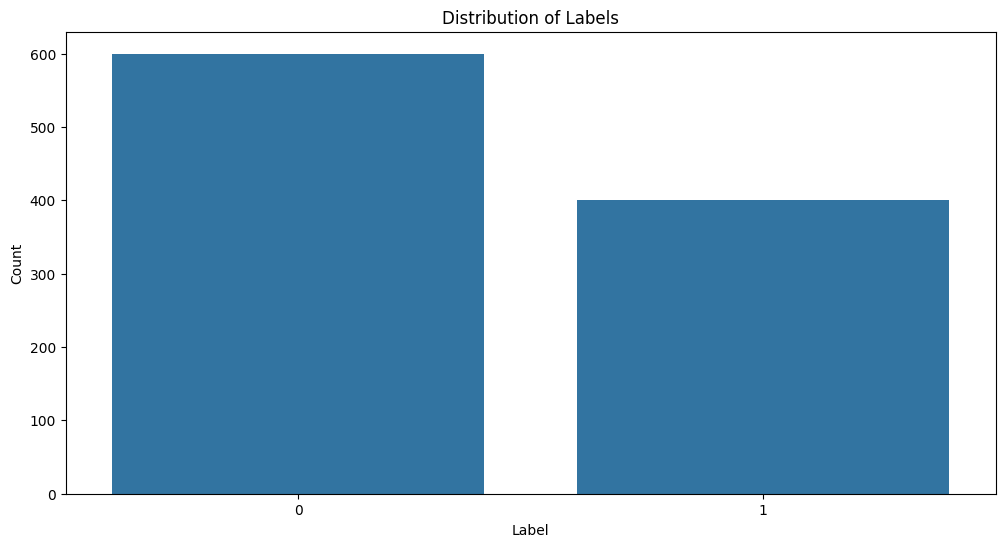

In [58]:
# get counts and percentages for each label
counts = pd.Series(labels).value_counts()
percentages = counts / len(labels) * 100

# print counts and percentages
print(f"Counts of each label:\n{counts}\n")
print(f"Percentages of each label:\n{percentages}\n")

# plot distribution of labels
plt.figure(figsize=(12, 6))
sns.countplot(x=labels)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### Analysis

As we can seem from this basic EDA, our dataset appears to clean and in the correct format for processing. We confirmed that our dataset does indeed contain 220,025 instances in the training set and checked for missing or duplicate entries. Next, we loaded 1000 random instances of the dataset and plotted 6 of the images with labels to get a better understanding of the data we will be working with and the image loading process we will use. Finally, we took a look at the class imbalances in the random sample.

Looking at the percentages and histogram plot above, we can see that the `0 = Negative` class is slightly overrepresented with ~60% of the samples having this label. This will be something that we need to keep in mind as we build and evaluate our classification model.

## Model Architecture

#### Reasoning
Because our problem space is image data and the task we aim to complete is a binary classification task, I have decided to go with a Convolutional Neural Network (CNN) architecture with a final dense layer that has a single output with a sigmoid activation function.

For this initial build, I am using the "out of the box" architecture described in the TensorFlow tutorial below. I will use this generic architecture to get a baseline AUC score (the metric the competition is scored against), then test different architectures and hyperparameters. Once I have a robust model working on a subset of the data, I will work to make improvements to the model.

-----

CNN model built with reference to this [TensorFlow CNN tutorial](https://www.tensorflow.org/tutorials/images/cnn).

In [59]:
# load 45,000 randomly sampled images (~20% of the training dataset)
# check if training images are already loaded to avoid memory overload
if 'images_train' not in locals() or 'images_train' not in globals():
    path = './data/train'
    images_train, labels_train = load_N_images(df_train, path, 45000)
    assert images_train.shape[0] == labels_train.shape[0], "Number of images and number of labels do not match"

    # split into train and validation sets
    # use stratified sampling to handle class imbalance
    X_train, X_val, y_train, y_val = train_test_split(images_train, labels_train, test_size=0.2, 
                                                    random_state=42, stratify=labels_train)

    # normalize the pixel values to be between 0 and 1
    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0
else:
    print("Training images already loaded")


Training images already loaded


X_train shape: (36000, 96, 96, 3)
y_train shape: (36000,)
X_val shape: (9000, 96, 96, 3)
y_val shape: (9000,)


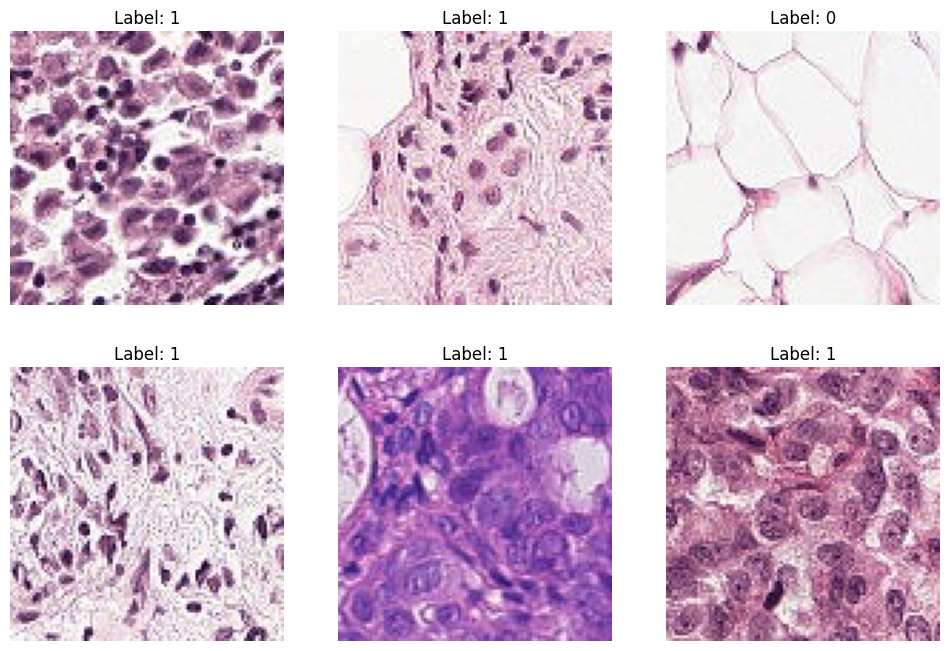

In [60]:
# check the shape of the train and validation sets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

# plot a few images from the training set
plot_images(X_train[:6], y_train[:6])

In [25]:
# create a simple CNN model
# convolutional base pattern from TensorFlow tutorial
model1 = Sequential()
model1.add(Input(shape=(96, 96, 3)))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid')) # use sigmoid for binary classification

# print model summary
model1.summary()

# explicitly set AUC name so label doesn't change from run to run
auc_metric = tf.keras.metrics.AUC(name='auc')

# compile the model
model1.compile(optimizer='adam', 
                loss=tf.keras.losses.binary_crossentropy,
                metrics=[auc_metric, Precision(), Recall(), 'accuracy'])

# fit the model
history1 = model1.fit(X_train, y_train, 
                      epochs=4,
                      batch_size=64,
                      validation_data=(X_val, y_val),
                      verbose=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
563/563 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.6724 - auc: 0.7109 - loss: 0.6069 - precision_2: 0.6279 - recall_2: 0.4297 - val_accuracy: 0.8000 - val_auc: 0.8702 - val_loss: 0.4524 - val_precision_2: 0.7310 - val_recall_2: 0.7956
Epoch 2/4
563/563 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.8003 - auc: 0.8658 - loss: 0.4460 - precision_2: 0.7759 - recall_2: 0.7111 - val_accuracy: 0.8163 - val_auc: 0.8894 - val_loss: 0.4179 - val_precision_2: 0.7875 - val_recall_2: 0.7442
Epoch 3/4
563/563 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.6864 - auc: 0.7153 - loss: 0.7029 - precision_2: 0.6333 - recall_2: 0.5241 - val_accuracy: 0.8092 - val_auc: 0.8800 - val_loss: 0.4280 - val_precision_2: 0.7675 - val_recall_2: 0.7541
Epoch 4/4
563/563 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.8016 - auc: 0.8691 - loss: 0.4404 - precision_2: 0.7834 - recall_2: 0.7036 - val_accuracy: 0.8290 - val_auc: 0.8987 - val_loss: 0.4014 - val_precision_2: 0.8026 - val_recall_2: 0.7

Final Train AUC: 0.87
Final Validation AUC: 0.9


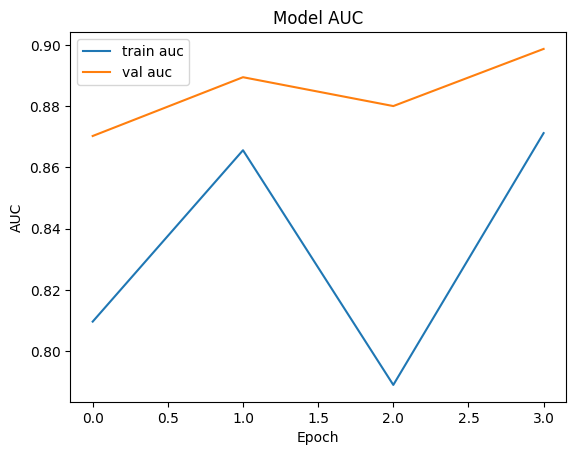

In [38]:
# store AUC value for train and validation sets
train_auc = history1.history['auc']
val_auc = history1.history['val_auc']

print(f"Final Train AUC: {round(train_auc[-1], 2)}")
print(f"Final Validation AUC: {round(val_auc[-1], 2)}")

# evaluate the model
plt.plot(history1.history['auc'], label='train auc')
plt.plot(history1.history['val_auc'], label='val auc')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Initial Architecture Results
As we can see, even with this very simple "off the shelf" CNN architecture—and only working on ~20% of the data—we already get a descent AUC of ~`0.87` on the validation split (there is a slight fluctuation from run to run).

I did have to play around with a few of the hyperparameters to get this initial model working decently well. I initially started training with 10 epochs, however after ~5 epochs, the AUC started oscillating violently, which indicated that the model was overfitting. I also set the loss function to binary cross-entropy (for a binary classification task) and set the batch size to 64.

Because the data set is both a binary classification problem and slightly imbalanced—and it is the metric this project is graded on in Kaggle—I decided to use AUC as my baseline performance metric. As I move into hyperparameter tuning, I will still monitor Precision, Recall and Accuracy; however, AUC will be my primary comparison metric.

Just as a reminder:
* **AUC** is the Area Under the (ROC) Curve—where the ROC curve is a two-dimensional plot with the True Positive Rate (TPR) on the y-axis and the False Positive Rate (FPR) on the x-axis. Higher AUC indicates the model is better at distinguishing between the classes.
* **Precision** measures the ratio of true positives to all predicted positives. "Of all the instances where my prediction was positive, how many were actually positive?"
* **Recall** measures the ratio of true positives to all actual positives. "Of all the actual positive instances, how many did I predict as positive?"
* **Accuracy** measures the ratio of correct predictions to total predictions. "What proportion of all my predictions were actually correct?"

One interesting thing to note here is that validation accuracy is consistently slightly higher than training accuracy. I'm not sure why this is, but I will continue to monitor it as I work to improve this model.

Before doing any further tuning though, I want to test this model on the test images and generate a baseline score.

In [61]:
# get a df with the test image ids
df_test = pd.read_csv('./data/sample_submission.csv')
# drop the label column
df_test = df_test.drop(columns=['label'])
df_test.head(10)

,id
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5
1,95596b92e5066c5c52466c90b69ff089b39f2737
2,248e6738860e2ebcf6258cdc1f32f299e0c76914
3,2c35657e312966e9294eac6841726ff3a748febf
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03
6,aa0307865281d4484ddf8c637c348292968b93a7
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb


In [62]:
# check the shape of the test dataframe
# note: there are 57,458 images in the test set
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
dtypes: object(1)
memory usage: 449.0+ KB


In [63]:
# loader for all test images
def load_test_images(df, path):
    images = []
    
    # add a tqdm progress bar
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        image_id = row['id']

        try:
            image_path = os.path.join(path, f'{image_id}.tif')
            image = Image.open(image_path)
            # ensure all images are 96x96
            image = image.resize((96,96))
            image = np.array(image)
            images.append(image)

        except Exception as e:
            print(f"Error loading image {image_id}: {e}")
            continue

    images = np.array(images)

    return images

In [64]:
# check if the test images have already been loaded (to avoid memory issues)
if 'test_images' not in locals() or 'test_images' not in globals():
    # load all test images
    path = './data/test'
    test_images = load_test_images(df_test, path)
    # check the shape of the test images
    print(test_images.shape)
    # normalize the pixel values to be between 0 and 1
    test_images = test_images.astype('float32') / 255.0
else:
    print("Test images already loaded")

Test images already loaded


In [65]:
# get predictions for the test images
predictions1 = model1.predict(test_images, batch_size=64)

# convert predictions to binary labels
# note: use a threshold of 0.5 for binary classification
pred_labels1 = (predictions1 > 0.5).astype(int)
# check the first 10 predicted labels
print(pred_labels1[:10])

898/898 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]]


In [54]:
# create a submission dataframe
submission1_df = pd.DataFrame({
    'id': df_test['id'],
    'label': pred_labels1.flatten()
})

# save the submission dataframe to a csv file
submission1_df.to_csv('./submissions/submission.csv', index=False)

### Submission Results

Alright, we have a baseline model working that has been trained on a subset of the data and is able to perform inference on the test images. I did two initial test runs with the current architecture. In the first run, I trained the model on 20,000 images from the training data (~10%). In the second run, I trained the model on 45,000 images from the training data (~20%). Here are the results of my Kaggle submission results from these initial runs:

| Run | # Training Samples | Kaggle Private Score | Kaggle Public Score |
|-----|--------------------|----------------------|---------------------|
| 1 | 20,000 | 0.7562 | 0.8126 |
| 2 | 45,000 | 0.7476 | 0.8135 |

These are the baseline scores I will compare against for my hyperparameter tuning.

## Model Improvement

#### Hypothesis 

In my baseline runs, I was getting wild oscillation in the AUC value beyond ~5 epochs. My hypothesis is that if I add some regularization to the model, while simultaneously increasing the training time (with early stopping), this will allow the model to better learn the data without overfitting.


In [66]:
# create the early stopping callback
# patience is how many epochs without improvement to wait before stopping
# mode is set to maximize the validation AUC
early_stopper = EarlyStopping(monitor='val_auc', 
                                 patience=4,
                                 mode='max',
                                 verbose=1, 
                                 restore_best_weights=True)

In [ ]:
# create an improved CNN model
# add batch normalization and dropout layers to each convolutional block
model2 = Sequential()
model2.add(Input(shape=(96, 96, 3)))

# first convolutional block
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.25))

# second convolutional block
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.25))

# third convolutional block
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.25))

# fully connected layers
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid')) # use sigmoid for binary classification

# print model summary
model2.summary()

# explicitly set AUC name so label doesn't change from run to run
auc_metric = tf.keras.metrics.AUC(name='auc')

# compile the model
model2.compile(optimizer='adam', 
                loss=tf.keras.losses.binary_crossentropy,
                metrics=[auc_metric, Precision(), Recall(), 'accuracy'])

# fit the model
history2 = model2.fit(X_train, y_train, 
                      epochs=48,
                      batch_size=64,
                      validation_data=(X_val, y_val),
                      verbose=1,
                      callbacks=[early_stopper])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,733,313 (6.61 MB)

 Trainable params: 1,732,609 (6.61 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/48
563/563 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.7578 - auc: 0.8251 - loss: 0.5605 - precision_3: 0.6966 - recall_3: 0.7202 - val_accuracy: 0.5988 - val_auc: 0.5982 - val_loss: 1.3231 - val_precision_3: 0.6957 - val_recall_3: 0.0044
Epoch 2/48
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.8169 - auc: 0.8792 - loss: 0.4226 - precision_3: 0.8098 - recall_3: 0.7146 - val_accuracy: 0.7626 - val_auc: 0.8291 - val_loss: 0.5372 - val_precision_3: 0.8262 - val_recall_3: 0.5188
Epoch 3/48
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.8320 - auc: 0.9004 - loss: 0.3865 - precision_3: 0.8321 - recall_3: 0.7318 - val_accuracy: 0.5978 - val_auc: 0.6688 - val_loss: 1.1071 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/48
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.8443 - auc: 0.9116 - loss: 0.3680 - precision_3: 0.8438 - recall_3: 0.7541 - val_accuracy: 0.7854 - val_auc: 0.8989 - val_loss: 0.4947 - val_precision_3: 0.6763 - val_r

Final Train AUC: 0.96
Final Validation AUC: 0.95


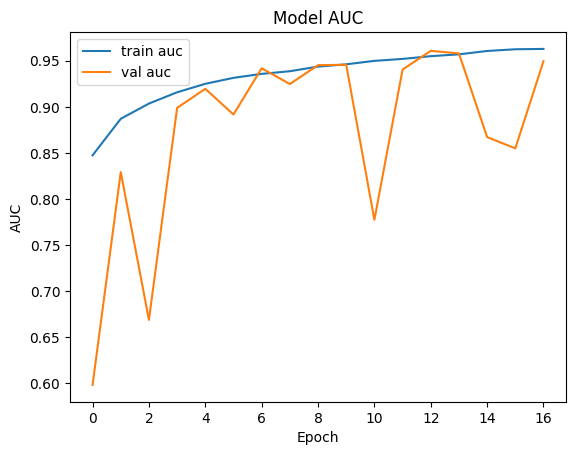

In [50]:
# store AUC value for train and validation sets
train_auc = history2.history['auc']
val_auc = history2.history['val_auc']

print(f"Final Train AUC: {round(train_auc[-1], 2)}")
print(f"Final Validation AUC: {round(val_auc[-1], 2)}")

# evaluate the model
plt.plot(history2.history['auc'], label='train auc')
plt.plot(history2.history['val_auc'], label='val auc')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [52]:
# get predictions for the test images
predictions2 = model2.predict(test_images, batch_size=64)

# convert predictions to binary labels
# note: use a threshold of 0.5 for binary classification
pred_labels2 = (predictions2 > 0.5).astype(int)
# check the first 10 predicted labels
print(pred_labels2[:10])

898/898 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]]


In [53]:
# create a submission dataframe
submission2_df = pd.DataFrame({
    'id': df_test['id'],
    'label': pred_labels2.flatten()
})

# save the submission dataframe to a csv file
submission2_df.to_csv('./submissions/submission_3.csv', index=False)

### Results

As we can see from the graph above, my hypothesis was correct! Final validation AUC went from ~`0.87` to ~`0.96`. Unfortunately, the results were not as impressive on the test images submitted to Kaggle. Here are my results across all three runs:

![Kaggle Results](./assets/cancer_detection_kaggle_results.png)

## Conclusion

Overall, this ended up being a very fun project to work on. There was definitely a learning curve in working with the image data, but once I was able to get the data loaded correctly, everything else went pretty smoothly. I'm honestly surprised at the results I was able to achieve with very little modification to the TensorFlow "out of the box" CNN architecture.

To extend this project, there is still a lot of room for improvement. First, I would want to implement a new dataloader that would allow me to load in all 220k images. I actually attempted to do this and completely overloaded the memory on my Mac—something I've literally never done before! I also only scratched the surface in terms of hyperparameter tuning. As we can see in the graph above, it appears that the train and validation AUC had not fully plateaued yet. I would like to continue playing around with the early stopping callback and test some longer patience levels. I would be very curious to see how this would turn out when trained on the full dataset.

One lingering question I have is why the validation AUC seems to be all over the place. In the initial baseline model, I was oddly getting a validation AUC that was consistently higher then the training AUC. And in this last run, we see it oscillating up and down while training AUC has a smooth, steady climb. I'm not sure what to make of these results, but it's definitely something I would like to explore further.